In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from matplotlib import cm, colors
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
import vr2p.signal
import scipy.signal
from scipy.stats import pearsonr

def get_bin_dF_and_event(pos_data, F_data,edges):
    '''Function takes in position data, fluorescent data, and the track bin info, 
    perform trial by trial binning, and return the  matrix with number of trials x number of position bins'''
    bin_pos = pos_data.copy()
    # change trials to rank order (for filling out matrix).
    bin_pos['trial_number'] = (bin_pos['trial_number'].rank(method='dense')-1).astype(int)
    # Assign bin position.
    bin_pos['bin'] = pd.cut(bin_pos.position,edges, include_lowest=True,labels=False).to_numpy().astype(int)
    bin_pos = bin_pos.loc[bin_pos.bin>=0] # valid bins only.
    # prepare binF matrix.
    num_trials = bin_pos.trial_number.max()+1
    num_bins = edges.size-1
    num_cells = F_data.shape[0]
    if np.isnan(num_trials): num_trials=0
    binF_mat = np.full((num_trials,num_bins,num_cells),np.nan) # holds mean fluorescence data.
    # Get frames per trial and bin.
    bin_pos = bin_pos.groupby(['trial_number','bin']).agg({'frame':list})
    # get mean dF value for each bin, trial frame set.
    for index, row in bin_pos.iterrows():
        binF_mat[index[0],index[1],:] = np.mean(F_data[:,row['frame']],axis=1)
    return binF_mat

def corr_matrix(A,B):
    
    corr_matrix = np.zeros((A.shape[1],B.shape[1]))

    for m in range(A.shape[1]):
        for n in range(B.shape[1]):
            corr, _ = pearsonr(A[:,m], B[:,n])
            corr_matrix[m,n] = corr
    
    return corr_matrix

def New_vs_SetA(New_Set, data, min_speed):
        
    # find the last session of New_Set
    cue_ind = []
    for session_id in range(len(data.vr)):
        vr = data.vr[session_id]
        trial = vr.trial.copy()
        if New_Set in list(trial.set.unique()):
            cue_ind.append(session_id)
            print(f'session {session_id}: {list(trial.set.unique())}')
    session_id = max(cue_ind)
    print(f'Last day of {New_Set} is {session_id}')
    
    vr = data.vr[session_id]
    trial = vr.trial.copy()
    

    position = vr.path.frame.copy().reset_index()

    # merge reward_id info
    position = position.merge(trial[['set','trial_number','reward_id','status']],on='trial_number',how = 'left')
    # filter for speed.
    position['speed'] = position.vr2p.rolling_speed(
            window_size = 100, ignore_threshold = 7.5)
    selected_frames = position['speed']>=min_speed
    position_speed_filtered = position.loc[selected_frames].copy()

    F = data.signals.multi_session.Fdemix[session_id]

    start_trial = 0
    end_trial = trial.trial_number.max()

    for cue_set in list(trial.set.unique()):
        print(cue_set)
        for rid in [1,2]:
            print(rid)
            # add period info.
            selected_trials = trial.loc[(trial.set == cue_set) & (trial.reward_id == rid) & (trial.trial_number.isin(range(start_trial,end_trial))) & (trial.status.isin(['CORRECT', 'INCORRECT'])),'trial_number']

            selected_position = position_speed_filtered.loc[(position_speed_filtered.trial_number.isin(selected_trials)),['set','frame','position','trial_number','interim_number','period_number','reward_id','status','speed']]

            dF, _ = vr2p.signal.df_over_f0(F,'maximin',subtract_min=True,
                sigma_baseline=df_sigma_baseline, window_size = df_window_size)

            # average bin fluorescent data.
            binF_mat=get_bin_dF_and_event(selected_position,dF,edges)
            binF = np.transpose(np.nanmean(binF_mat,axis=0)) 
            #smooth_binF = scipy.signal.convolve2d(binF,np.ones((1, 3))/3, mode='same',boundary='symm')
            if (cue_set == 'Cue Set A') and (rid == 1):
                binF_mat_A_N = binF_mat
                binF_A_N = binF
            if (cue_set == 'Cue Set A') and (rid == 2):
                binF_mat_A_F = binF_mat
                binF_A_F = binF
            if (cue_set == cue_set_select) and (rid == 1):
                binF_mat_other_N = binF_mat
                binF_other_N = binF
            if (cue_set == cue_set_select) and (rid == 2):
                binF_mat_other_F = binF_mat
                binF_other_F = binF
    #New_NF_corr = corr_matrix(binF_other_N,binF_other_F)
    OLD_NF_corr = corr_matrix(binF_A_N,binF_A_F)
    #New_N_A_N_corr = corr_matrix(binF_other_N,binF_A_N)
    #New_N_A_F_corr = corr_matrix(binF_other_F,binF_A_F)
    
    #return New_NF_corr,OLD_NF_corr, New_N_A_N_corr, New_N_A_F_corr
    return OLD_NF_corr

In [ ]:
import vr2p

animals = ['Tyche-A4 Set A-E','Tyche-A5 Set A-E','Tyche-A7 Set A-E']

New_NF = []
OLD_NF = []
New_N_A_N = []
New_F_A_F = []

min_speed = 5
df_sigma_baseline = 200 
df_window_size = 200
track_length = 230
bin_size = 5
edges = np.arange(0,track_length + bin_size, bin_size)


for anm_n,animal in enumerate(animals): 
    print(animal)
    path = f'/nrs/spruston/Tyche/vr2p_datasets/{animals[anm_n]}'
    data = vr2p.ExperimentData(path) 
    # get each animals'last day correlation matrices for New_N x New_F, New_N vs A_N, New_F vs A_F, for valid new cue sets.
    for cue_set in ['Cue Set B','Cue Set C','Cue Set D','Cue Set E']:
        if animal == 'Tyche-A5 Set A-E' and cue_set == 'Cue Set D':
            continue    
        cue_set_select = cue_set
        
        New_NF_corr,OLD_NF_corr, New_N_A_N_corr, New_N_A_F_corr = New_vs_SetA(cue_set_select, data, min_speed)
        New_NF.append(New_NF_corr)
        OLD_NF.append(OLD_NF_corr)
        New_N_A_N.append(New_N_A_N_corr)
        New_F_A_F.append(New_N_A_F_corr)
        


In [ ]:
import vr2p

animals = ['Tyche-A4 Set A-E','Tyche-A5 Set A-E','Tyche-A7 Set A-E']

OLD_NF = []

min_speed = 5
df_sigma_baseline = 200 
df_window_size = 200
track_length = 230
bin_size = 5
edges = np.arange(0,track_length + bin_size, bin_size)


for anm_n,animal in enumerate(animals): 
    print(animal)
    path = f'/nrs/spruston/Tyche/vr2p_datasets/{animals[anm_n]}'
    data = vr2p.ExperimentData(path) 
    # get each animals'last day correlation matrices for New_N x New_F, New_N vs A_N, New_F vs A_F, for valid new cue sets.
    for cue_set in ['Cue Set B','Cue Set C','Cue Set D','Cue Set E']:
        if animal == 'Tyche-A5 Set A-E' and cue_set == 'Cue Set D':
            continue    
        cue_set_select = cue_set
        
        OLD_NF_corr = New_vs_SetA(cue_set_select, data, min_speed)
        OLD_NF.append(OLD_NF_corr)

        


In [ ]:
#New_NF = np.array(New_NF)
OLD_NF = np.array(OLD_NF)
#New_N_A_N = np.array(New_N_A_N)
#New_F_A_F = np.array(New_F_A_F)


In [ ]:
#np.save('./New_NF.npy',New_NF)
np.save('./OLD_NF.npy',OLD_NF)

#np.save('./New_N_A_N.npy',New_N_A_N)
#np.save('./New_F_A_F.npy',New_F_A_F)

In [2]:
New_NF = np.load('./New_NF.npy')
New_N_A_N = np.load('./New_N_A_N.npy')
New_F_A_F = np.load('./New_F_A_F.npy')


In [5]:
mat.shape

(46, 46)

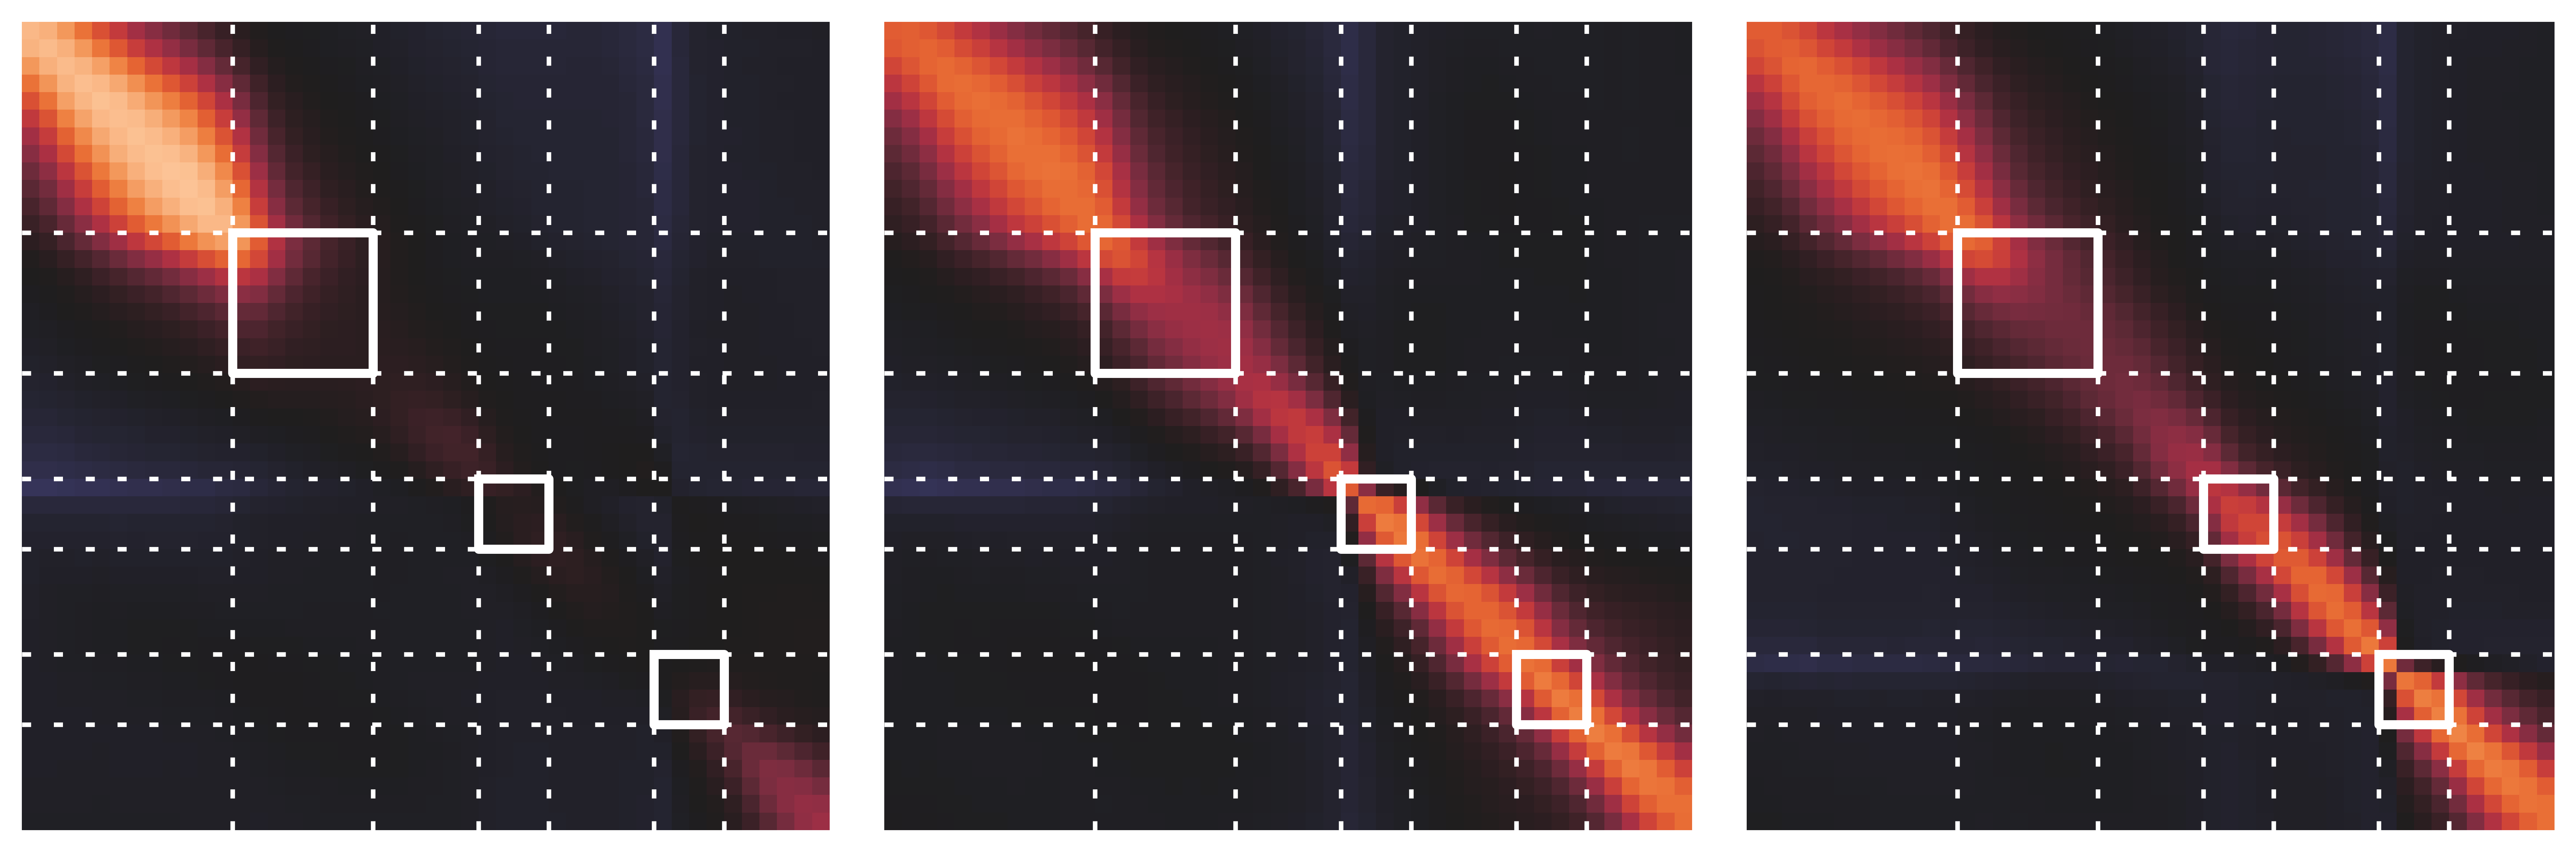

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime

# Assuming that New_NF, New_N_A_N, and New_F_A_F are numpy arrays containing 46 x 46 matrices

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4), dpi=600)
cmap = sns.color_palette("icefire", as_cmap=True)
vmin, vmax = -1, 1

# Enumerate through the mean matrices
for i, mat in enumerate([np.mean(New_NF, axis=0), np.mean(New_N_A_N, axis=0), np.mean(New_F_A_F, axis=0)]):
    ax = axs[i]
    sns.heatmap(mat, vmin=vmin, vmax=vmax, cmap=cmap, ax=ax, cbar=False, xticklabels=False, yticklabels=False, linewidths=0)
    
    ax.set_aspect('equal')  # make each subplot square
    
    # Add grid lines
    for lines in [12, 20, 26, 30, 36, 40]:  # Removed 46 from the list
        axs[i].axvline(lines, linestyle=(0, (2, 5)), color='white', linewidth=1.5)  # dotted vertical lines
        axs[i].axhline(lines, linestyle=(0, (2, 5)), color='white', linewidth=1.5)  # dotted horizontal lines

    # Draw square bounding box
    for (low, high) in [(12, 20), (26, 30), (36, 40)]:
        axs[i].plot([low, high, high, low, low], [low, low, high, high, low], color='white',linewidth=3)  

plt.tight_layout()
today = datetime.datetime.now().strftime('%Y_%m_%d')  # get today's date
plt.savefig(f'new_cue_heatmap_plot_{today}.pdf', format='pdf', dpi=600)

plt.show()


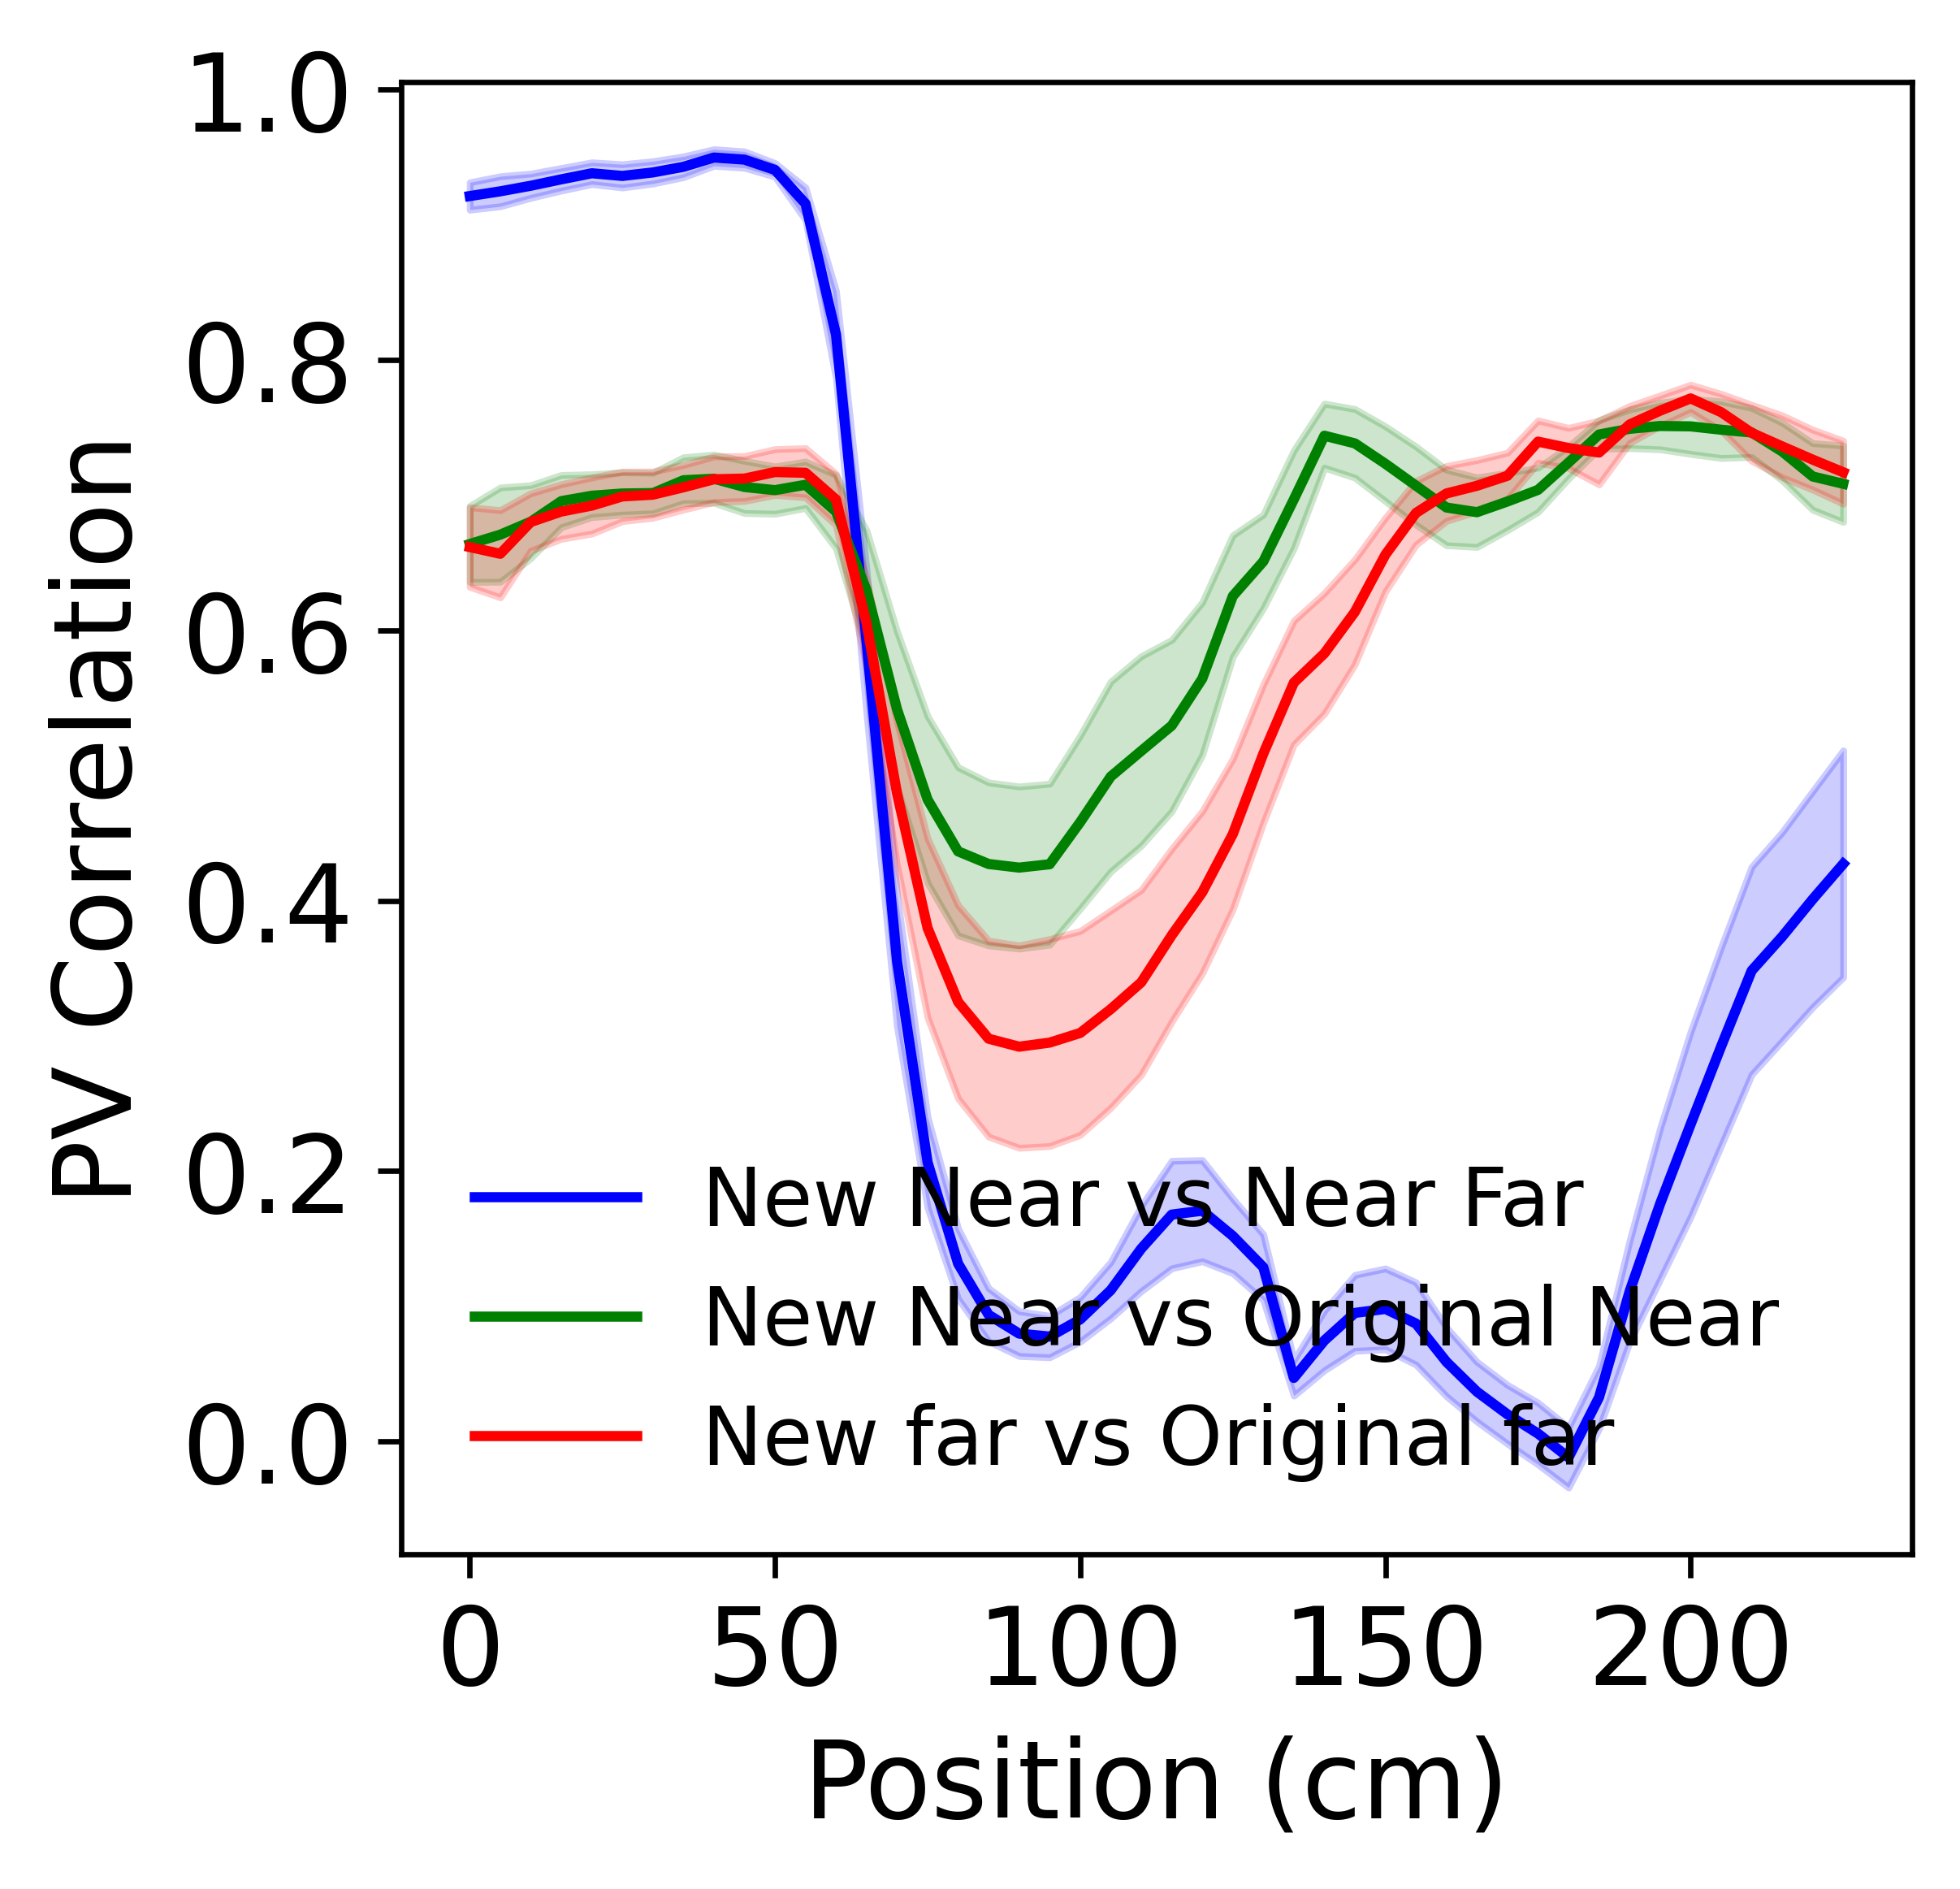

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42

# Function to calculate the average of diagonal elements
def avg_diagonal(arr):
    return np.mean(np.diagonal(arr, axis1=1, axis2=2), axis=0)

# Calculate the average diagonals and SEM for each array
avg_diag_New_NF = avg_diagonal(New_NF)
avg_diag_New_N_A_N = avg_diagonal(New_N_A_N)
avg_diag_New_F_A_F = avg_diagonal(New_F_A_F)

sem_New_NF = sem(New_NF.diagonal(axis1=1, axis2=2), axis=0)
sem_New_N_A_N = sem(New_N_A_N.diagonal(axis1=1, axis2=2), axis=0)
sem_New_F_A_F = sem(New_F_A_F.diagonal(axis1=1, axis2=2), axis=0)

# Plot the data
fig, ax = plt.subplots(figsize=(4, 4), dpi=600)

x = np.arange(0, 46)  # x-axis values: 1 to 46 (since there are 46 diagonal elements)

ax.plot(x, avg_diag_New_NF, label='New Near vs Near Far', linestyle='-', color='blue')
ax.fill_between(x, avg_diag_New_NF - sem_New_NF, avg_diag_New_NF + sem_New_NF, color='blue', alpha=0.2)

ax.plot(x, avg_diag_New_N_A_N, label='New Near vs Original Near', linestyle='-', color='green')
ax.fill_between(x, avg_diag_New_N_A_N - sem_New_N_A_N, avg_diag_New_N_A_N + sem_New_N_A_N, color='green', alpha=0.2)

ax.plot(x, avg_diag_New_F_A_F, label='New far vs Original far', linestyle='-', color='red')
ax.fill_between(x, avg_diag_New_F_A_F - sem_New_F_A_F, avg_diag_New_F_A_F + sem_New_F_A_F, color='red', alpha=0.2)

# Customize the plot
xlabels = [0,50,100,150,200]
ax.set_xlabel('Position (cm)', fontsize=16)
ax.set_ylabel('PV Correlation', fontsize=16)
plt.xticks([0,10,20,30,40], xlabels)
ax.tick_params(axis='both', labelsize=16)
ax.legend(frameon=False,fontsize=12)
#plt.savefig('new_cue_set_quantification.pdf', dpi=600)
# Show the plot
plt.show()


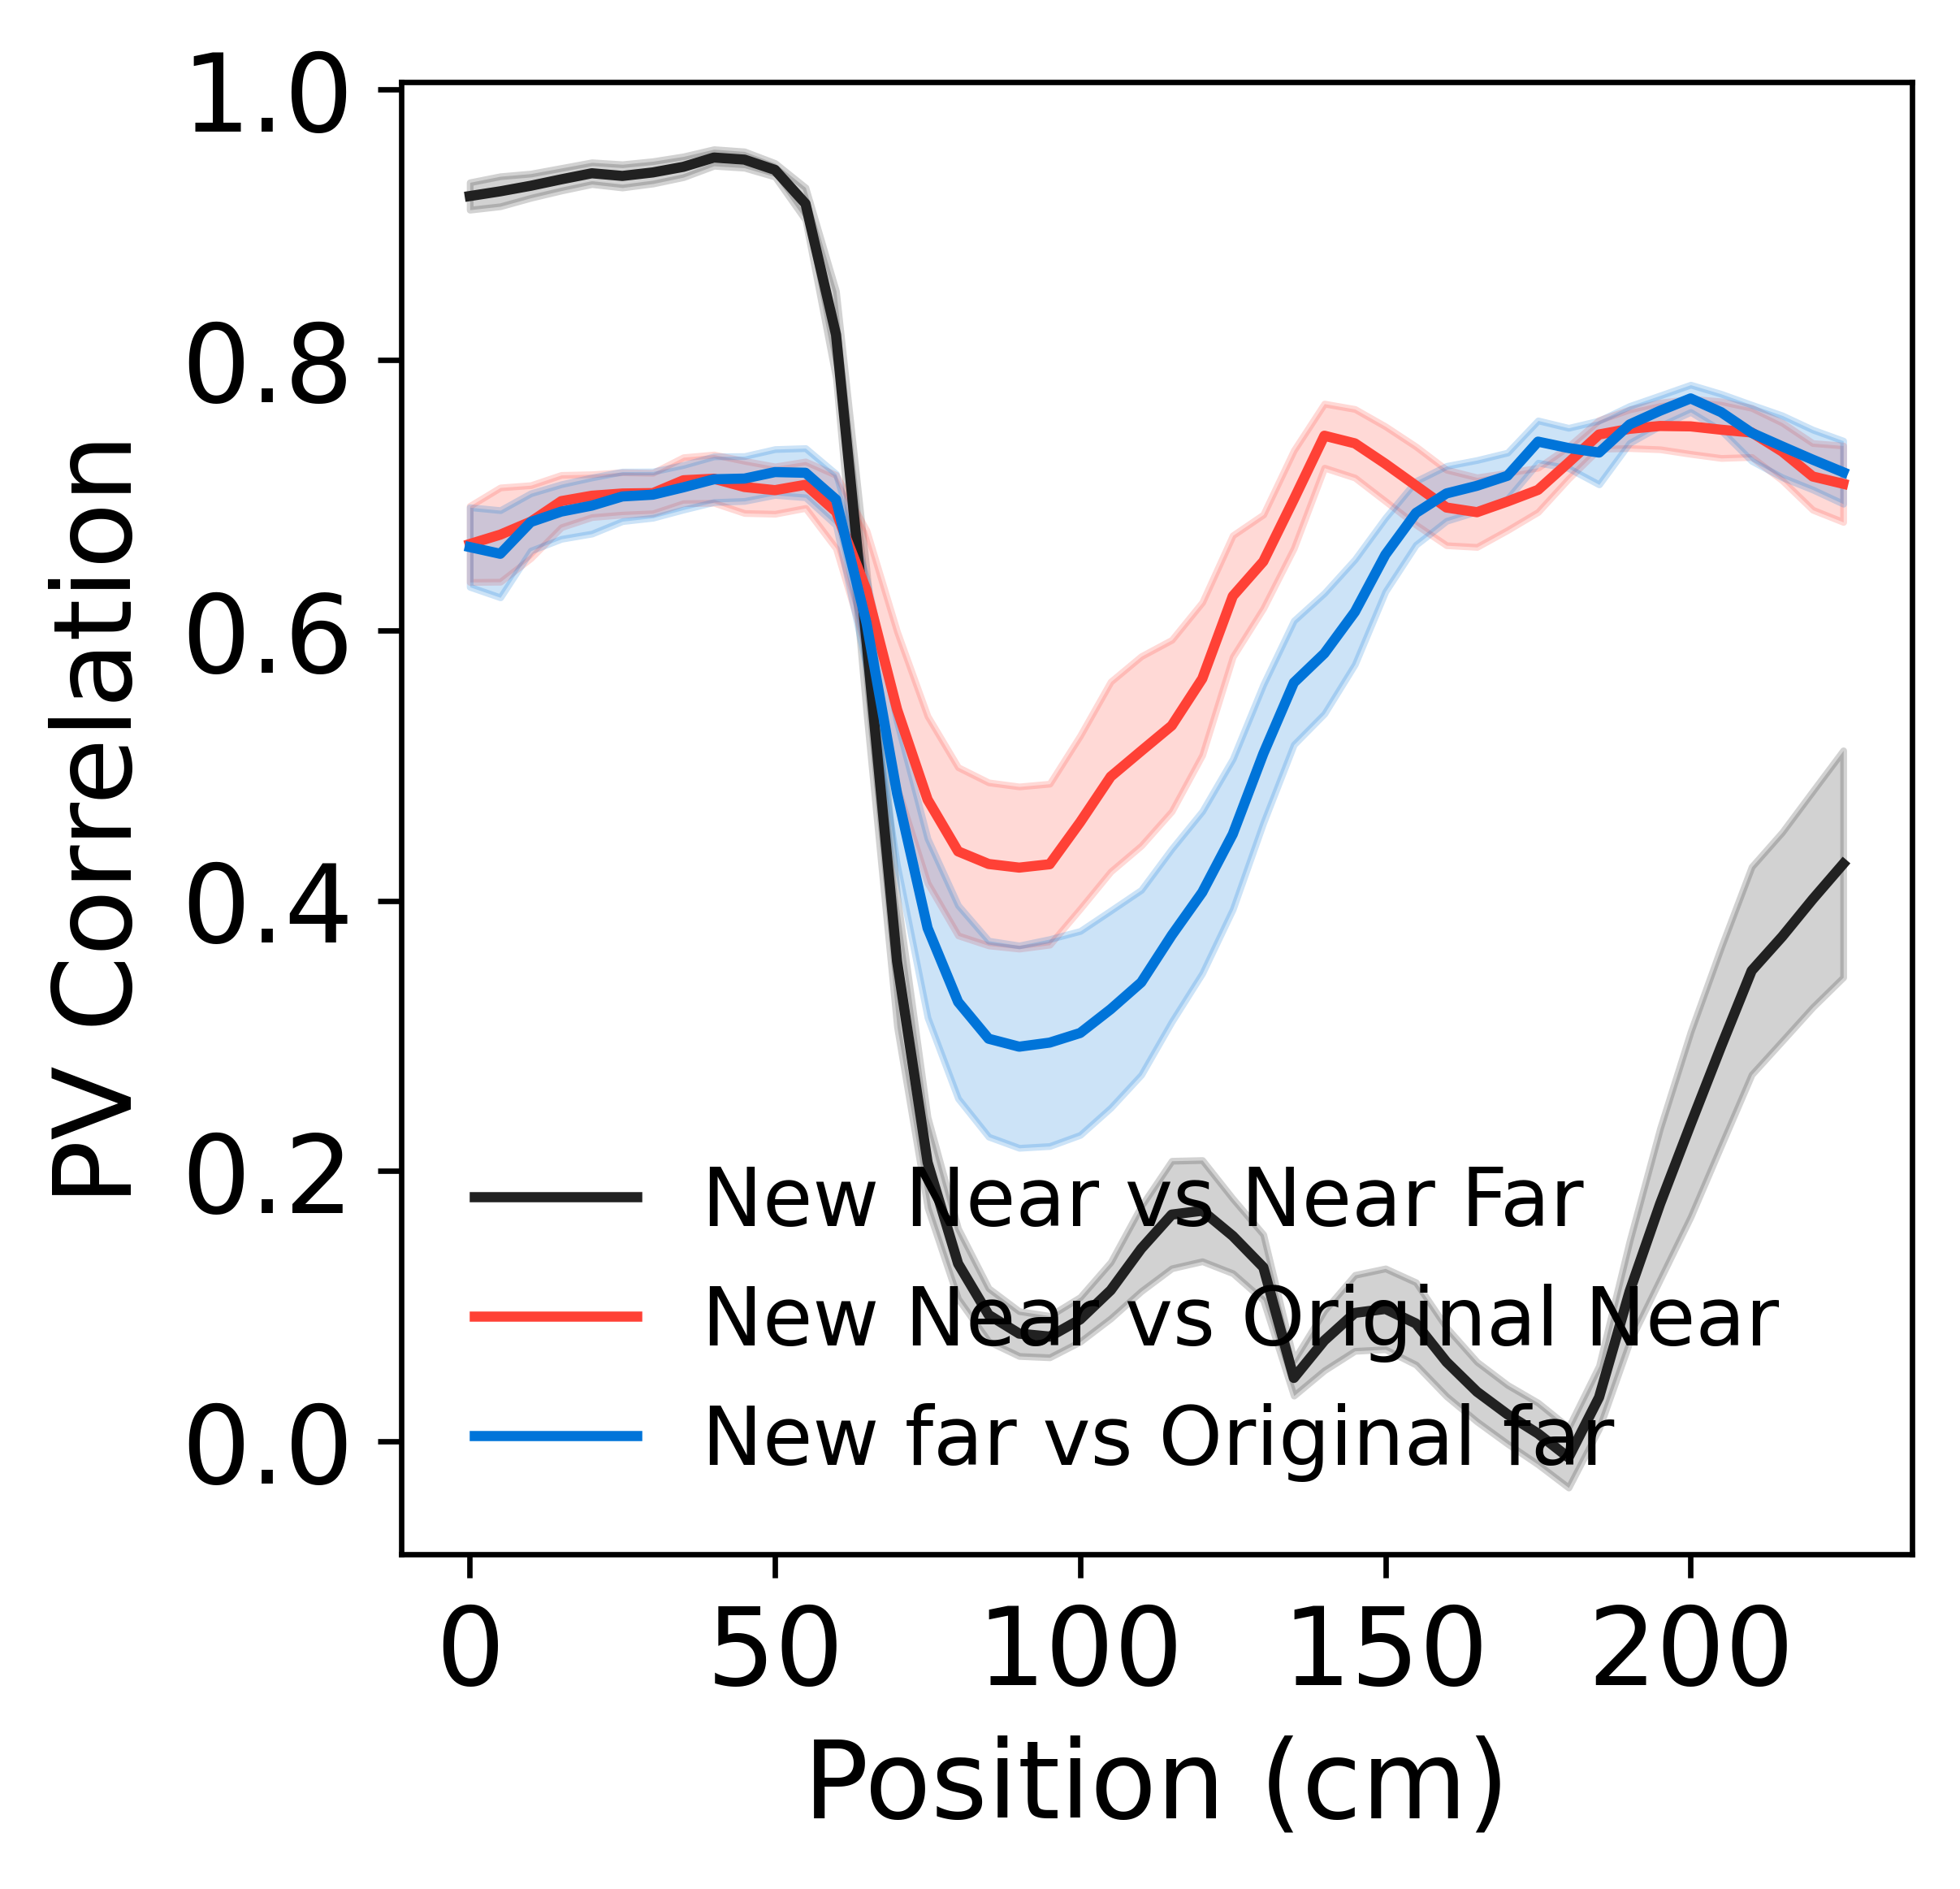

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42

# Function to calculate the average of diagonal elements
def avg_diagonal(arr):
    return np.mean(np.diagonal(arr, axis1=1, axis2=2), axis=0)

# Calculate the average diagonals and SEM for each array
avg_diag_New_NF = avg_diagonal(New_NF)
avg_diag_New_N_A_N = avg_diagonal(New_N_A_N)
avg_diag_New_F_A_F = avg_diagonal(New_F_A_F)

sem_New_NF = sem(New_NF.diagonal(axis1=1, axis2=2), axis=0)
sem_New_N_A_N = sem(New_N_A_N.diagonal(axis1=1, axis2=2), axis=0)
sem_New_F_A_F = sem(New_F_A_F.diagonal(axis1=1, axis2=2), axis=0)

# Plot the data
fig, ax = plt.subplots(figsize=(4, 4), dpi=600)

x = np.arange(0, 46)  # x-axis values: 1 to 46 (since there are 46 diagonal elements)

ax.plot(x, avg_diag_New_NF, label='New Near vs Near Far', linestyle='-', color='#212121')
ax.fill_between(x, avg_diag_New_NF - sem_New_NF, avg_diag_New_NF + sem_New_NF, color='#212121', alpha=0.2)

ax.plot(x, avg_diag_New_N_A_N, label='New Near vs Original Near', linestyle='-', color='#FF4136')
ax.fill_between(x, avg_diag_New_N_A_N - sem_New_N_A_N, avg_diag_New_N_A_N + sem_New_N_A_N, color='#FF4136', alpha=0.2)

ax.plot(x, avg_diag_New_F_A_F, label='New far vs Original far', linestyle='-', color='#0074D9')
ax.fill_between(x, avg_diag_New_F_A_F - sem_New_F_A_F, avg_diag_New_F_A_F + sem_New_F_A_F, color='#0074D9', alpha=0.2)

# Customize the plot
xlabels = [0,50,100,150,200]
ax.set_xlabel('Position (cm)', fontsize=16)
ax.set_ylabel('PV Correlation', fontsize=16)
plt.xticks([0,10,20,30,40], xlabels)
ax.tick_params(axis='both', labelsize=16)
ax.legend(frameon=False,fontsize=12)
plt.savefig('new_cue_set_quantification.pdf', dpi=600)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42

# Function to calculate the average of diagonal elements
def avg_diagonal(arr):
    return np.mean(np.diagonal(arr, axis1=1, axis2=2), axis=0)

# Calculate the average diagonals and SEM for each array
avg_diag_New_NF = avg_diagonal(New_NF)
avg_diag_New_N_A_N = avg_diagonal(New_N_A_N)
avg_diag_New_F_A_F = avg_diagonal(New_F_A_F)

sem_New_NF = sem(New_NF.diagonal(axis1=1, axis2=2), axis=0)
sem_New_N_A_N = sem(New_N_A_N.diagonal(axis1=1, axis2=2), axis=0)
sem_New_F_A_F = sem(New_F_A_F.diagonal(axis1=1, axis2=2), axis=0)

# Plot the data
fig, ax = plt.subplots(figsize=(4, 4), dpi=600)

x = np.arange(0, 46)  # x-axis values: 1 to 46 (since there are 46 diagonal elements)

# Modify linestyle and color
ax.plot(x, avg_diag_New_NF, label='New Near vs Near Far', linestyle='-', color='black')
ax.fill_between(x, avg_diag_New_NF - sem_New_NF, avg_diag_New_NF + sem_New_NF, color='gray', alpha=0.2)

ax.plot(x, avg_diag_New_N_A_N, label='New Near vs Original Near', linestyle='--', color='black')
ax.fill_between(x, avg_diag_New_N_A_N - sem_New_N_A_N, avg_diag_New_N_A_N + sem_New_N_A_N, color='gray', alpha=0.2)

ax.plot(x, avg_diag_New_F_A_F, label='New far vs Original far', linestyle=':', color='black')
ax.fill_between(x, avg_diag_New_F_A_F - sem_New_F_A_F, avg_diag_New_F_A_F + sem_New_F_A_F, color='gray', alpha=0.2)

# Customize the plot
xlabels = [0,50,100,150,200]
ax.set_xlabel('Position (cm)', fontsize=16)
ax.set_ylabel('PV Correlation', fontsize=16)
plt.xticks([0,10,20,30,40], xlabels)
ax.tick_params(axis='both', labelsize=16)
ax.legend(frameon=False,fontsize=12)

plt.show()


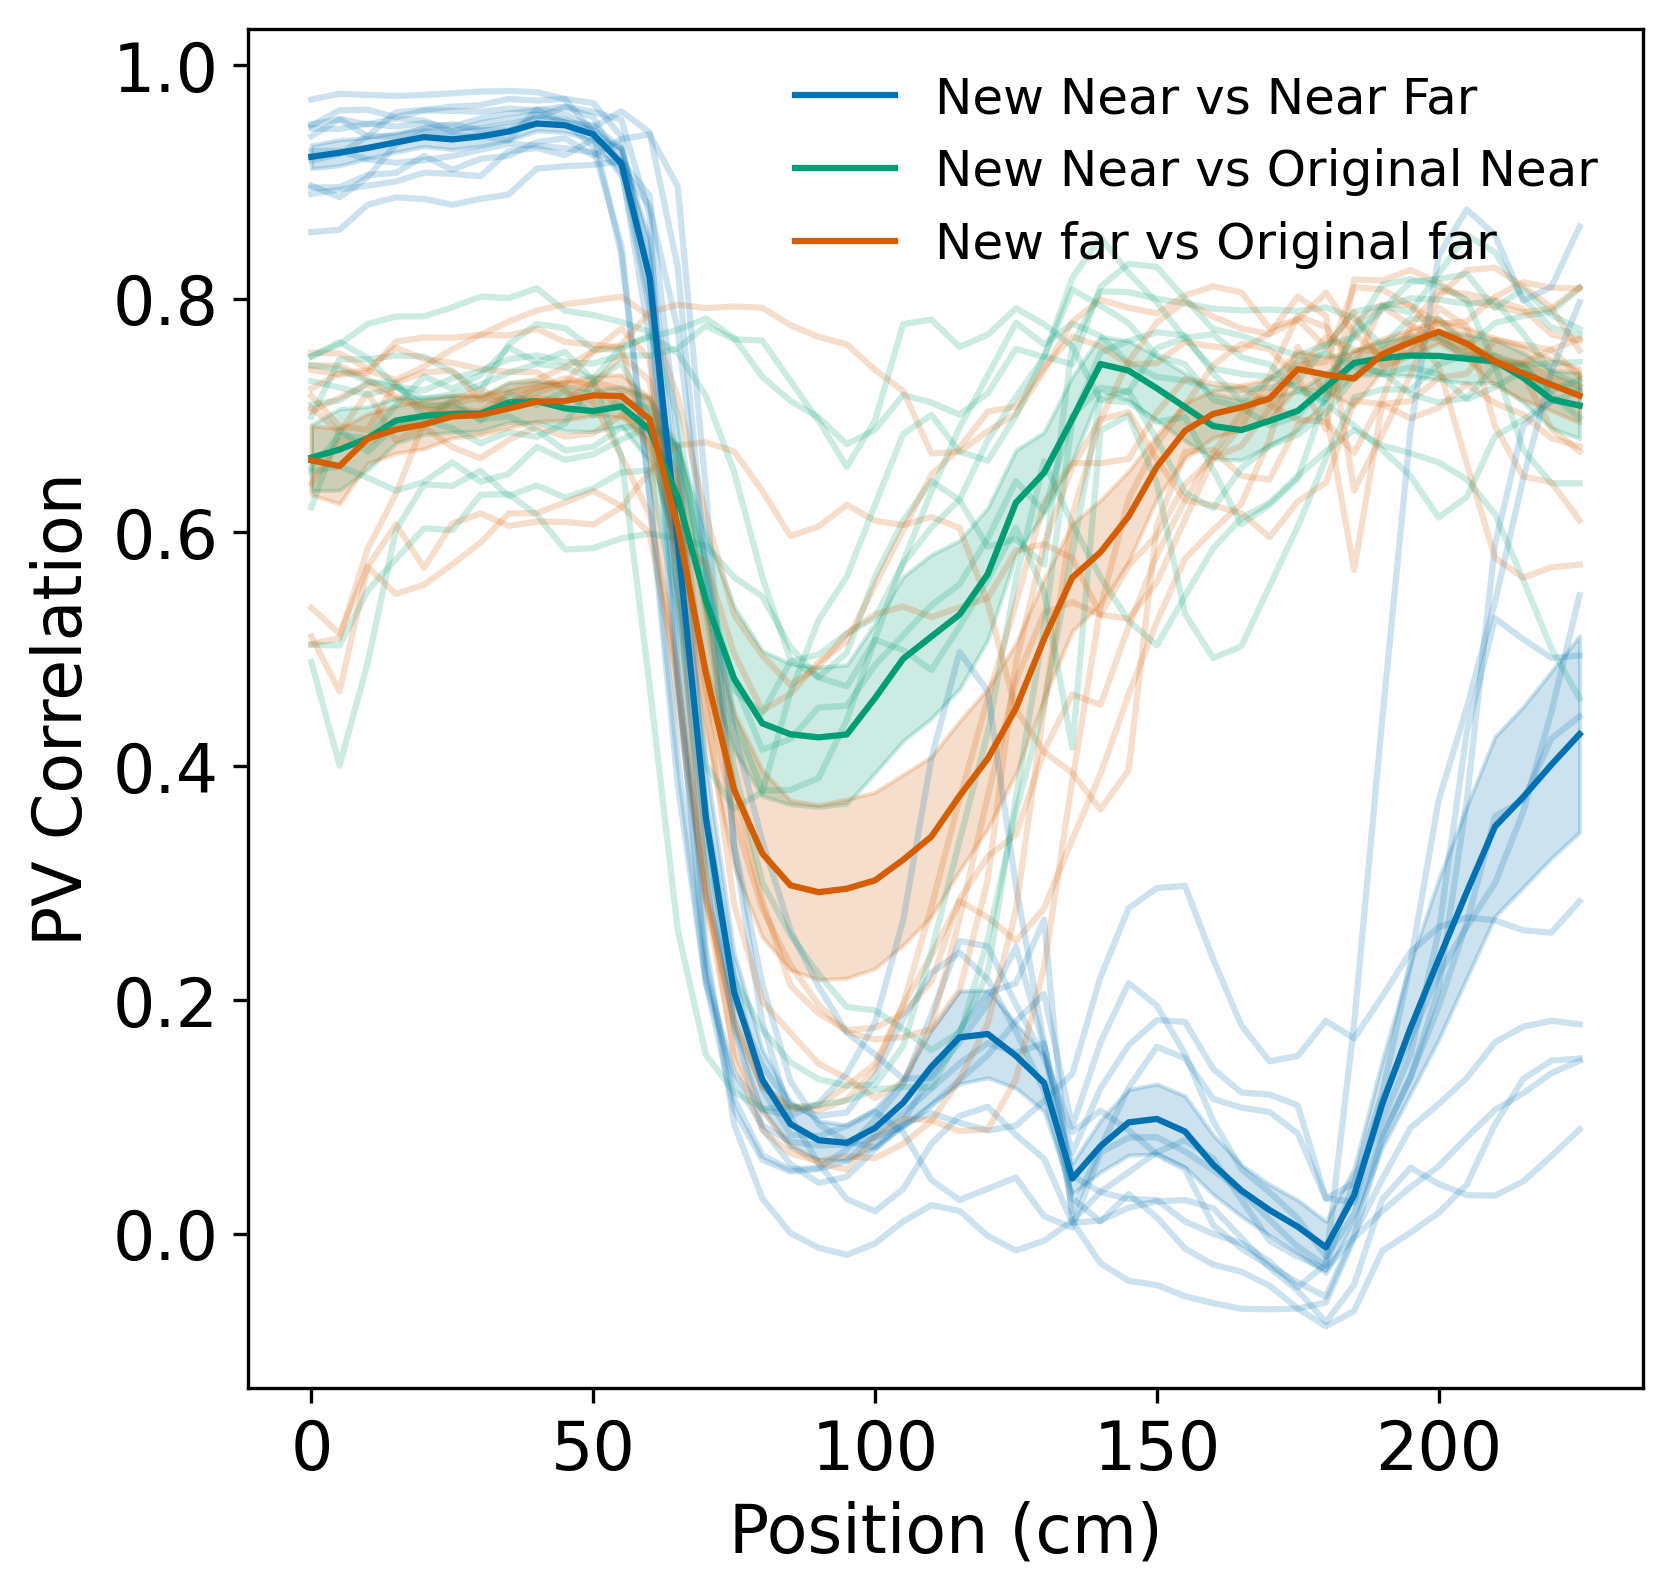

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem


# Function to calculate the average of diagonal elements
def avg_diagonal(arr):
    return np.mean(np.diagonal(arr, axis1=1, axis2=2), axis=0)

# Calculate the average diagonals and SEM for each array
avg_diag_New_NF = avg_diagonal(New_NF)
avg_diag_New_N_A_N = avg_diagonal(New_N_A_N)
avg_diag_New_F_A_F = avg_diagonal(New_F_A_F)

sem_New_NF = sem(New_NF.diagonal(axis1=1, axis2=2), axis=0)
sem_New_N_A_N = sem(New_N_A_N.diagonal(axis1=1, axis2=2), axis=0)
sem_New_F_A_F = sem(New_F_A_F.diagonal(axis1=1, axis2=2), axis=0)

# Plot the data
fig, ax = plt.subplots(figsize=(6, 6), dpi=300)

x = np.arange(0, 46)  # x-axis values: 1 to 46 (since there are 46 diagonal elements)

# Set colorblind-friendly colors
color1 = '#0072b2'
color2 = '#009e73'
color3 = '#d55e00'

# Plot individual lines as semi-transparent in the background
for i in range(New_NF.shape[0]):
    ax.plot(x, New_NF[i].diagonal(), alpha=0.2, color=color1)
    ax.plot(x, New_N_A_N[i].diagonal(), alpha=0.2, color=color2)
    ax.plot(x, New_F_A_F[i].diagonal(), alpha=0.2, color=color3)

# Plot the mean and SEM
ax.plot(x, avg_diag_New_NF, label='New Near vs Near Far', linestyle='-', color=color1)
ax.fill_between(x, avg_diag_New_NF - sem_New_NF, avg_diag_New_NF + sem_New_NF, color=color1, alpha=0.2)

ax.plot(x, avg_diag_New_N_A_N, label='New Near vs Original Near', linestyle='-', color=color2)
ax.fill_between(x, avg_diag_New_N_A_N - sem_New_N_A_N, avg_diag_New_N_A_N + sem_New_N_A_N, color=color2, alpha=0.2)

ax.plot(x, avg_diag_New_F_A_F, label='New far vs Original far', linestyle='-', color=color3)
ax.fill_between(x, avg_diag_New_F_A_F - sem_New_F_A_F, avg_diag_New_F_A_F + sem_New_F_A_F, color=color3, alpha=0.2)

# Customize the plot
xlabels = [0,50,100,150,200]
ax.set_xlabel('Position (cm)', fontsize=16)
ax.set_ylabel('PV Correlation', fontsize=16)
plt.xticks([0,10,20,30,40], xlabels)
ax.tick_params(axis='both', labelsize=16)
ax.legend(frameon=False,fontsize=12)

# Show the plot
plt.show()
